In [2]:
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CallbackList
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
df = pd.read_csv('fer2013.csv')
df


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [4]:
df.emotion.unique()


array([0, 2, 4, 6, 3, 5, 1])

In [5]:
emotion_label_to_text = {0: 'Angry',
                                1: 'Disgust',
                                2: 'Fear',
                                3: 'Happy',
                                4: 'Sad',
                                5: 'Surprise',
                                6: 'Neutral'}

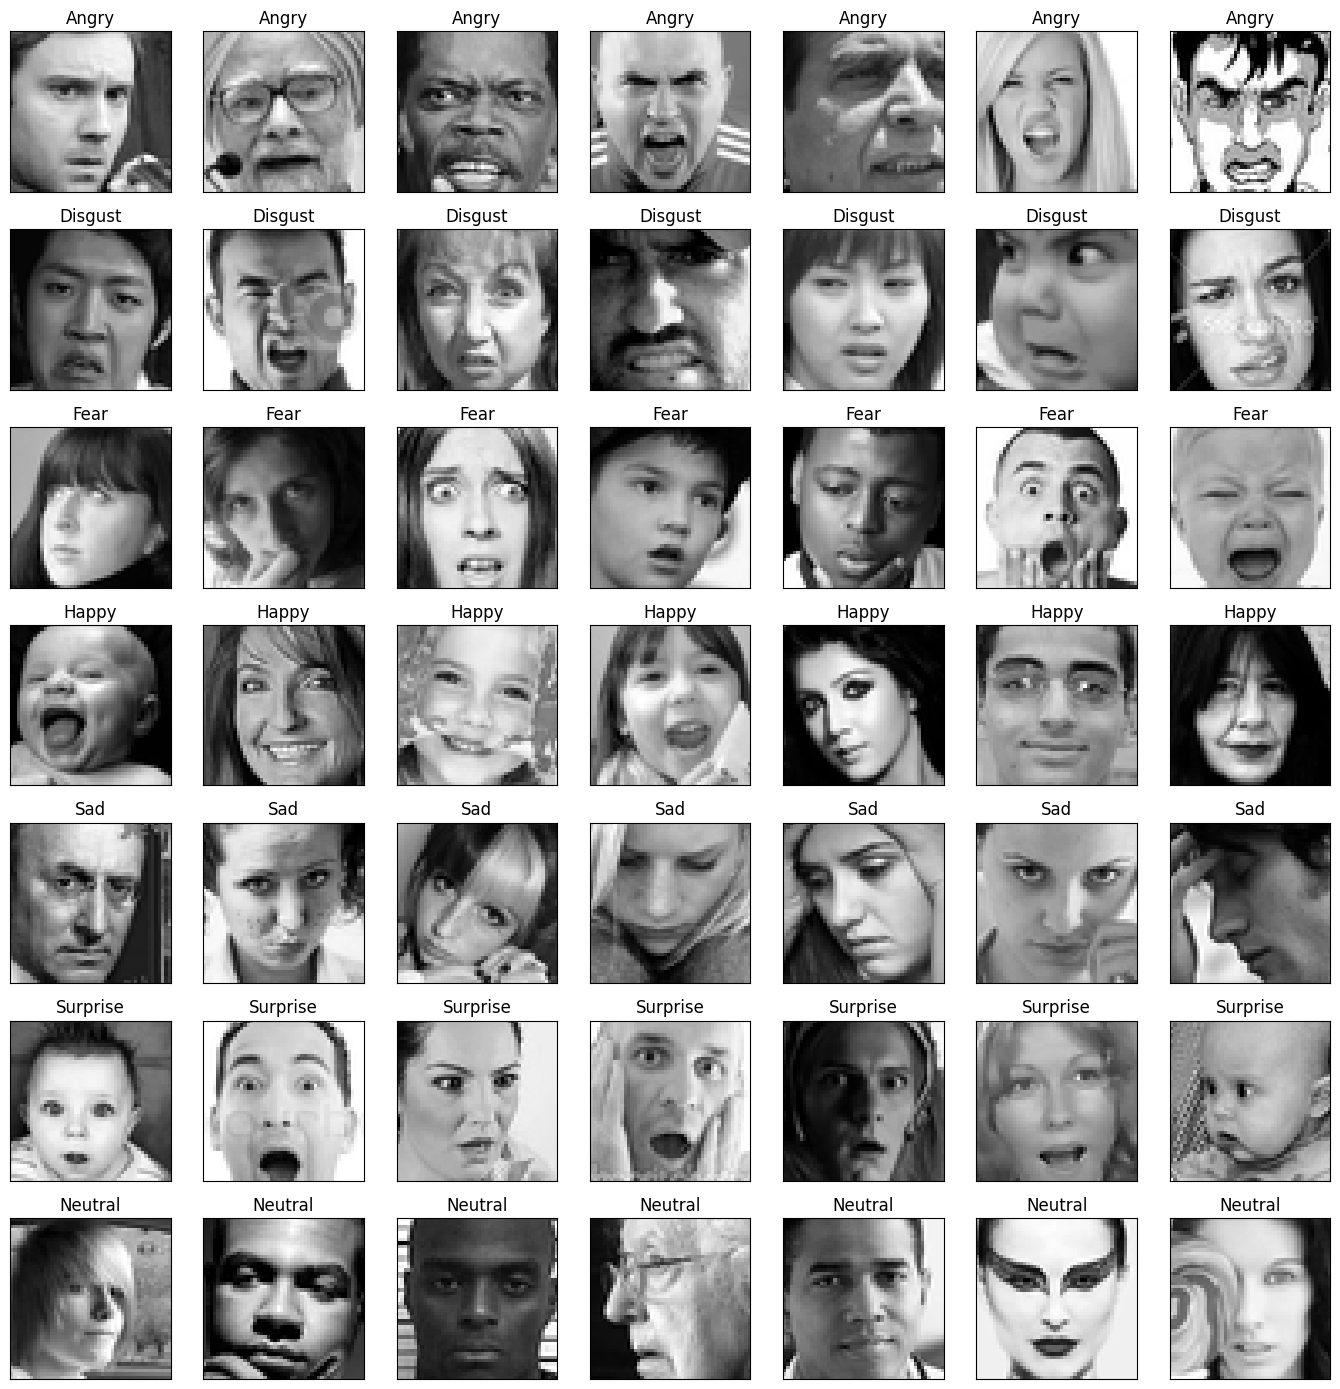

In [6]:
##
fig = plt.figure(1,(14, 14))
k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df["emotion"] == label].pixels.iloc[k]
        px = np.array(px.split(" ")).reshape(48, 48).astype("float32")
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap="gray")
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

In [7]:
interested_label = [3,4,6] # Happy, Sad, Neutral


In [8]:
df = df[df['emotion'].isin(interested_label)]
df.shape

(21264, 3)

In [9]:
## data compatible for our model
img_array = df.pixels.apply(lambda x: np.array(x.split(" ")).reshape(48, 48).astype("float32"))
img_array = np.stack(img_array, axis=0)
img_array.shape

(21264, 48, 48)

In [10]:
img_array

array([[[ 24.,  32.,  36., ..., 173., 172., 173.],
        [ 25.,  34.,  29., ..., 173., 172., 173.],
        [ 26.,  29.,  25., ..., 172., 172., 174.],
        ...,
        [159., 185., 157., ..., 157., 156., 153.],
        [136., 157., 187., ..., 152., 152., 150.],
        [145., 130., 161., ..., 142., 143., 142.]],

       [[  4.,   0.,   0., ...,  27.,  24.,  25.],
        [  1.,   0.,   0., ...,  26.,  23.,  26.],
        [  0.,   0.,   0., ...,  27.,  26.,  26.],
        ...,
        [  0.,   0.,   0., ...,  34.,  32.,  30.],
        [  0.,   0.,   0., ...,  33.,  31.,  30.],
        [  0.,   0.,   0., ...,  30.,  29.,  30.]],

       [[ 20.,  17.,  19., ..., 187., 176., 162.],
        [ 22.,  17.,  17., ..., 195., 180., 171.],
        [ 17.,  17.,  18., ..., 203., 193., 175.],
        ...,
        [  1.,   1.,   1., ..., 106., 115., 119.],
        [  2.,   2.,   1., ..., 103., 111., 119.],
        [  2.,   2.,   2., ...,  99., 107., 118.]],

       ...,

       [[ 50.,  36.,  17

In [11]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [12]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{np.int64(3): np.int64(0), np.int64(4): np.int64(1), np.int64(6): np.int64(2)}

In [13]:
x_train, x_test, y_train, y_test = train_test_split(img_array, 
                                                    img_labels, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=img_labels)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(17011, 48, 48)
(4253, 48, 48)
(17011, 3)
(4253, 3)


In [14]:
x_train = x_train.reshape(-1, 48, 48, 1)

In [15]:
## extract img_width, img_height, Img_depth, num_classes

img_width, img_height = x_train.shape[1], x_train.shape[2]
num_classes = y_train.shape[1]
img_depth = x_train.shape[3]
print(img_width, img_height, img_depth, num_classes)

48 48 1 3


In [16]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [17]:
#deep cnn architecture
# convolutional layer -> batch normalization -> convolutinal 2D -> batch normalization -> max pooling -> dropout
# this process will continue until you add batch normalizatiion till 7th layer

In [18]:
def build_net(optim):
    net = Sequential(name = "DCNN")
    net.add(
        Conv2D(
            filters=64, 
            kernel_size=(5, 5), 
            padding='same',
            activation='elu', 
            input_shape=(img_width, img_height, img_depth), 
            kernel_initializer='he_normal',
            name = 'conv2d_1'
        )
    )
    
    ##bN is used after dense or before convo layer
    net.add(BatchNormalization(
        name = "batch_normalization_1"))
    net.add(
        Conv2D(
            filters = 64 ,
            kernel_size = (5,5),
            activation = "elu",
            padding = "same",
            kernel_initializer = "he_normal",
            name = "conv2d_2"
        )
    )
    net.add(BatchNormalization(
        name = "batch_normalization_2"))
    net.add(
        MaxPooling2D(
            pool_size = (2,2),
            name = "max_pooling2d_1"
        )
    )
    net.add(Dropout(0.4,name = "droput_1"))
    net.add(
        Conv2D(
            filters = 128 ,
            kernel_size = (3,3),
            activation = "elu",
            padding = "same",
            kernel_initializer = "he_normal",
            name = "conv2d_3"
        )
    )
    net.add(BatchNormalization(
        name = "batch_normalization_3"))
    net.add(
        Conv2D(
            filters = 128 ,
            kernel_size = (3,3),
            activation = "elu",
            padding = "same",
            kernel_initializer = "he_normal",
            name = "conv2d_4"
        )
    )
    net.add(BatchNormalization(
        name = "batch_normalization_4"))
    net.add(
        MaxPooling2D(
            pool_size = (2,2),
            name = "max_pooling2d_2"
        )
    )
    net.add(Dropout(0.4,name = "droput_2"))

    net.add(
        Conv2D(
            filters = 256 ,
            kernel_size = (3,3),
            activation = "elu",
            padding = "same",
            kernel_initializer = "he_normal",
            name = "conv2d_5"
        )
    )
    net.add(BatchNormalization(
        name = "batch_normalization_5"))
    net.add(
        Conv2D(
            filters = 256 ,
            kernel_size = (3,3),
            activation = "elu",
            padding = "same",
            kernel_initializer = "he_normal",
            name = "conv2d_6"
        )
    )
    net.add(BatchNormalization(
        name = "batch_normalization_6"))
    net.add(
        MaxPooling2D(
            pool_size = (2,2),
            name = "max_pooling2d_3"
        )
    )
    net.add(Dropout(0.5,name = "droput_3"))

    net.add(Flatten(name = "flatten"))
    net.add(
        Dense(
            128,
            activation = "elu",
            kernel_initializer = "he_normal",
            name = "dense_1"
        )
    )
    net.add(BatchNormalization(
        name = "batch_normalization_7"))
    net.add(Dropout(0.6,name = "droput_4"))
    net.add(
        Dense(num_classes,
            activation = "softmax",
            name = "out_layer"
        )
    )

    net.compile(
        loss = "categorical_crossentropy",
        optimizer = optim,
        metrics = ["accuracy"]
    )
    net.summary()
    return net

In [19]:
##callbacks -- early stopping, reduce learning rate on plateau
#callbacks are used when we do not know how many epochs we need to train the model
# so we use callbacks to stop the training when the model stops improving
#early stopping are used to stop the training when the model stops improving
#reduce learning rate on plateau are used to reduce the learning rate when the model stops improving
#learning rate is a hyperparameter that controls how much to change the weights of the model

early_stopping = EarlyStopping(
    monitor='val_accuracy', # monitor the validation loss
    min_delta=0.00005, # minimum change in the monitored quantity to qualify as an improvement
    patience=11,# number of epochs with no improvement after which training will be stopped
    verbose=1, # verbosity is set to 1 to print messages when the callback is triggered
    restore_best_weights=True # restore model weights from the epoch with the best value of the monitored quantity
)


reducelr = ReduceLROnPlateau(
    monitor='val_accuracy', # monitor the validation loss
    factor=0.5, # factor reduces lr by 50 percent
    patience=7, # number of epochs with no improvement after which learning rate will be reduced
    verbose=1, # verbosity is set to 1 to print messages when the callback is triggered
    min_lr= 1e-7 # minimum learning rate
)

callbcks = [early_stopping, reducelr]

In [20]:
#imagedata generator
#1 -- load the images from the directory
#2 -- apply the real time data augmentation
#augmentation - creating modified versions of images to increase the size of the dataset
# to make it more robust and to prevent overfitting
#3 - generate batches of tensor image data with real-time data augmentation


In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True)
train_datagen.fit(x_train)

In [24]:
batch_size =32
epochs = 1
optims = [
    optimizers.Nadam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        name='Nadam'
    ),
    optimizers.Adam(
        learning_rate=0.001,)
]

In [25]:
model = build_net(optims[1])
history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=callbcks
)

Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ droput_1 (Dropout)              │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ droput_2 (Dropout)              │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ droput_3 (Dropout)              │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,395,075 (9.14 MB)

 Trainable params: 2,393,027 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

532/532 ━━━━━━━━━━━━━━━━━━━━ 372s 686ms/step - accuracy: 0.3815 - loss: 1.5261 - val_accuracy: 0.4764 - val_loss: 1.0310 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.
